In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?dl=0

--2021-07-07 05:00:42--  https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dtw18saps0231yn/BrainTumorData.zip [following]
--2021-07-07 05:00:42--  https://www.dropbox.com/s/raw/dtw18saps0231yn/BrainTumorData.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc540609a4ea1e35ed2300b50c26.dl.dropboxusercontent.com/cd/0/inline/BR1zI0lesch7tkZGAJN3Ve3E294RT9G1svQKy8NOSnIr49BIGwXYN7o4S-a9LNYfZh5kKXeLJQhekrprPMyM55tYF6Hyzyr6whlgZlRqr1eVSKydAyj2jrYyRXzaGrKvU0y3FRfwI0M2Ibn-5lURjAKz/file# [following]
--2021-07-07 05:00:42--  https://uc540609a4ea1e35ed2300b50c26.dl.dropboxusercontent.com/cd/0/inline/BR1zI0lesch7tkZGAJN3Ve3E294RT9G1svQKy8NOSnIr49BIGwXYN7o4S-a9LNYfZh5

In [ ]:
!unzip /content/BrainTumorData.zip?dl=0

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import math
import shutil      # Helps move files around different folders
import glob        # Helps retrieve pathnames matching a specified pattern

In [5]:
# Count image count in respective classes (0 - Brain Tumor, 1 - Healthy)

ROOT_DIR = '/content/BrainTumorData/Brain Tumor Data Set'     # Root folder
number_of_images = {}                                         # Directory to hold key- folder name and value - image count in that folder

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))    # os.listdir() returns the directories present inside given path as a list

number_of_images.items()

dict_items([('Healthey', 2087), ('Brain Tumor', 2513)])

# Splitting the dataset 
70% Training data, 15% validation data and 15% test data

In [6]:
# Function to create the training, validation and test folders

def dataFolder(path, split):
  # If folder doesn't already exist, then create and add images
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+path+"/"+dir)
      # Choosing 70% of the existing images of each class randomly, -5 so we don't want to lose too many images
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR,dir)),
                                  size = (math.floor(split * number_of_images[dir]) - 5),
                                  replace = False):
        origin = os.path.join(ROOT_DIR, dir, img)
        destination = os.path.join("./"+path,dir)
        shutil.copy(origin, destination)    # Transfer the file
        os.remove(origin)
  else:
    print(f"{path} folder already exists!")

In [7]:
dataFolder("train",0.7)

In [8]:
dataFolder("val", 0.15) # Validation folder

In [9]:
dataFolder("test", 0.15) # Test folder

# Build the model

## Import necessary libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing import image
import keras

# Using Transfer Learning to improve model accuracy

## Import necessary libraries

In [11]:
base_model = MobileNet(input_shape=(224,224,3), include_top= False)

17235968/17225924 [==============================] - 0s 0us/step


In [12]:
for layer in base_model.layers:
  layer.trainable = False       # Do not re-train the model

In [13]:
base_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f9807e1ad10>>

In [14]:
# Clubbing our model with the pretrained model

X = Flatten()(base_model.output)
x = Dense(units=2, activation='sigmoid', name='predictions')(X)

model = Model(base_model.input, x)     # Final model

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )

Preparing data using Image Generator

In [17]:
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [18]:
train_data = train_datagen.flow_from_directory(directory= "/content/train", 
                                               target_size=(224,224), 
                                               batch_size=32)

Found 3209 images belonging to 2 classes.


In [19]:
val_data = val_datagen.flow_from_directory(directory= "/content/val", 
                                           target_size=(224,224), 
                                           batch_size=32)

Found 679 images belonging to 2 classes.


In [20]:
test_data = test_datagen.flow_from_directory(directory= "/content/test", target_size=(224,224), batch_size=32)

Found 679 images belonging to 2 classes.


In [21]:
# Early stopping to stop training once model performance does not increase anymore and Model checkpoint to save model after some interval

from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1, mode='auto')

mc = ModelCheckpoint(monitor='val_accuracy', filepath="./bestmodel.h5", verbose=1, mode='auto', save_best_only=True)

cb = [es, mc]

In [22]:
history = model.fit_generator(generator=train_data, 
                              steps_per_epoch=10, 
                              epochs=30, 
                              verbose=1, 
                              validation_data=val_data, 
                              validation_steps=16, 
                              callbacks=cb)

Epoch 1/30
10/10 [==============================] - 56s 4s/step - loss: 4.8218 - accuracy: 0.5608 - val_loss: 1.3651 - val_accuracy: 0.8242

Epoch 00001: val_accuracy improved from -inf to 0.82422, saving model to ./bestmodel.h5
Epoch 2/30
10/10 [==============================] - 31s 3s/step - loss: 1.2452 - accuracy: 0.8716 - val_loss: 0.8210 - val_accuracy: 0.8691

Epoch 00002: val_accuracy improved from 0.82422 to 0.86914, saving model to ./bestmodel.h5
Epoch 3/30
10/10 [==============================] - 31s 3s/step - loss: 0.6891 - accuracy: 0.8959 - val_loss: 1.1031 - val_accuracy: 0.8594

Epoch 00003: val_accuracy did not improve from 0.86914
Epoch 4/30
10/10 [==============================] - 31s 3s/step - loss: 0.7924 - accuracy: 0.8829 - val_loss: 0.4851 - val_accuracy: 0.9238

Epoch 00004: val_accuracy improved from 0.86914 to 0.92383, saving model to ./bestmodel.h5
Epoch 5/30
10/10 [==============================] - 31s 3s/step - loss: 0.4441 - accuracy: 0.9108 - val_loss: 0

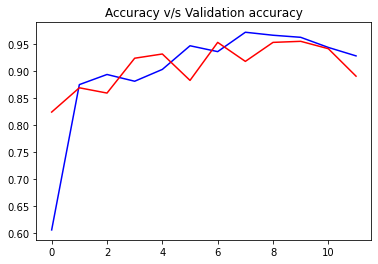

In [23]:
h = history.history

plt.plot(h['accuracy'], c='blue')
plt.plot(h['val_accuracy'], c='red')
plt.title('Accuracy v/s Validation accuracy')
plt.show()

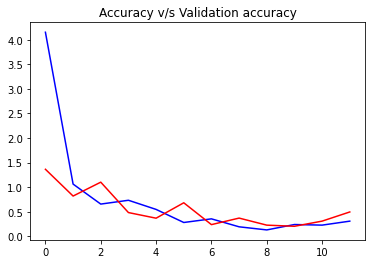

In [24]:
plt.plot(h['loss'], c='blue')
plt.plot(h['val_loss'], c='red')
plt.title('Accuracy v/s Validation accuracy')
plt.show()

In [25]:
# Model accuracy

from keras.models import load_model

model = load_model("/content/bestmodel.h5")     # Load the best model

# ACCURACY OBTAINED AFTER TRANSFER LEARNING USING MOBILENET ARCHITECTURE

In [26]:
acc = model.evaluate_generator(test_data)[1]

print(f"The accuracy obtained by our model is {acc*100}%")

The accuracy obtained by our model is 95.28718590736389%


Healthy brain.


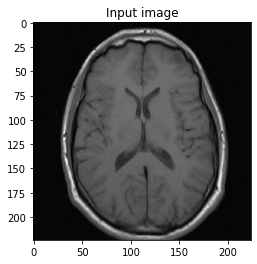

In [27]:
# Path for the image to see if it predics the correct class

path = "/content/val/Healthey/Not Cancer  (1025).jpg" # Healthy
img = image.load_img(path, target_size=(224,224) )

i = image.img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))


if pred == 0:
  print("Brain Tumor Found!")
else:
  print("Healthy brain.")


# to display the image  
plt.imshow(input_arr[0])
plt.title("Input image")
plt.show()

Brain Tumor Found!


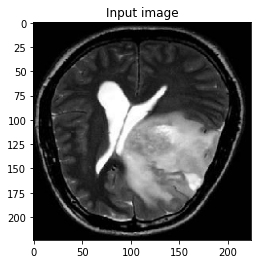

In [28]:
path = "/content/val/Brain Tumor/Cancer (1014).jpg" # Tumorous
img = image.load_img(path, target_size=(224,224) )

i = image.img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))


if pred == 0:
  print("Brain Tumor Found!")
else:
  print("Healthy brain.")


# to display the image  
plt.imshow(input_arr[0])
plt.title("Input image")
plt.show()